In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/burger/hackaton2023_train.par


In [2]:
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score

import matplotlib.ticker as mtick 
from matplotlib.ticker import PercentFormatter 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tabulate import tabulate

import warnings
warnings.filterwarnings("ignore")

sns.set_theme()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import pandas as pd
df = pd.read_parquet('/kaggle/input/burger/hackaton2023_train.par', engine='pyarrow')

# Подготовка данных

In [4]:
def prepare_cols(df):
    
    res = df.copy()
    res['format_name'] = res['format_name'].apply(lambda x: np.nan if x == 'Не заполнено' else x)
    res['startdatetime'] = pd.to_datetime(res['startdatetime'], format="%y-%m-%d %H:%M:%S")
    res['date_diff_post'] = res['date_diff_post'].fillna(100)
    
    cols_for_ord_en = ['format_name', 'dish_name']
    enc = OrdinalEncoder()
    res[cols_for_ord_en] = enc.fit_transform(res[cols_for_ord_en])
    
    res['format_name'] = res['format_name'].fillna(res["format_name"].median())
    
    res = res.drop(columns=['group_name'], axis=1)
    
    return res

X = prepare_cols(df)

In [5]:
X.describe().T

,count,mean,min,25%,50%,75%,max,std
customer_id,12129384.0,19809542.263361,29891.0,10108525.0,21274586.0,28038562.0,46661804.0,11389040.436254
date_diff_post,12129384.0,36.663855,0.0,10.0,23.0,50.0,100.0,34.795681
buy_post,12129384.0,0.796485,0.0,1.0,1.0,1.0,1.0,0.402613
revenue,12129384.0,106.799476,0.01,44.99,79.98,131.7725,14499.71,107.438512
startdatetime,12129384,2023-02-20 12:19:13.394690048,2022-09-02 00:00:39,2022-12-06 16:12:06,2023-02-22 11:04:22,2023-05-09 18:48:02,2023-08-01 23:57:46,NaN
dish_name,12129384.0,660.265681,0.0,515.0,645.0,899.0,1037.0,250.767695
ownareaall_sqm,12129384.0,215.513003,0.0,104.9,210.4,300.0,978.7,122.590689
format_name,12129384.0,4.190277,0.0,1.0,5.0,6.0,7.0,2.489212


In [6]:
X.head()

,customer_id,date_diff_post,buy_post,revenue,startdatetime,dish_name,ownareaall_sqm,format_name
0,29891,9.0,1,69.99,2022-12-05 12:03:58,589.0,300.0,1.0
1,29891,9.0,1,190.00,2022-12-05 12:03:58,982.0,300.0,1.0
2,29891,9.0,1,9.99,2022-12-05 12:03:58,900.0,300.0,1.0
3,29891,9.0,1,119.99,2022-12-05 12:03:58,1035.0,300.0,1.0
4,29891,9.0,1,119.99,2022-12-05 14:28:35,625.0,300.0,1.0


### Заполнение ошибки в данных о площади помещения

In [7]:
X['ownareaall_sqm'] = X['ownareaall_sqm'].replace(0, np.nan)
X['ownareaall_sqm'] = X['ownareaall_sqm'].fillna(X.groupby('format_name')['ownareaall_sqm'].transform('mean'))

### Удаление выброса стоимости заказа

In [8]:
mask = X['revenue'] >= X.quantile(0.99, numeric_only=True)['revenue']
X = X[~mask]

### Усредняем цену блюда для замены им наименования

In [9]:
X['revenue'] = X.groupby('dish_name')["revenue"].transform("median")

### Создаём синтетические фичи

In [10]:
X['user_start'] = X.groupby('customer_id')["startdatetime"].transform("min")
X['time'] = X['startdatetime'] - X['user_start'] # от первого заказа в днях
X['12_hours'] = X['time'] // np.timedelta64(12,'h') # в полуднях
X['nweek'] = X['time'] // np.timedelta64(1,'W') # в неделях

In [11]:
X['day_of_week'] = X['startdatetime'].dt.dayofweek
X['day_part'] = X['startdatetime'].dt.hour

In [12]:
X['one_check_revenue'] = X.groupby(['customer_id', 'startdatetime'])['revenue'].transform('sum')
X['check_len'] = X.groupby(['customer_id', 'startdatetime'])['one_check_revenue'].transform('count')

In [13]:
X['dish_pop_u'] = X.groupby(['customer_id', 'dish_name'])['dish_name'].transform('count').astype(np.float32) / X.groupby('customer_id')['dish_name'].transform('count')
X['dish_pop_u_check'] = X.groupby(['customer_id', 'startdatetime'])['dish_pop_u'].transform('sum') / X['check_len']
# Создаем столбец с популярностью в целом
X['dish_pop_g'] = X.groupby('dish_name')['customer_id'].transform('count').astype(np.float32) / X.shape[0]
X['dish_pop_g_check'] = X.groupby(['customer_id', 'startdatetime'])['dish_pop_g'].transform('sum') / X['check_len']

### Формируем новую таблицу с первичным ключом - (customer_id, startdatetime)

In [14]:
df_by_check = X.drop_duplicates(subset=['customer_id', 'startdatetime'], keep='last')
df_by_check = df_by_check.drop(columns=['revenue'])

In [15]:
df_by_check['check_avg'] = df_by_check.groupby('customer_id')["one_check_revenue"].transform("mean")
df_by_check['check_len_avg'] = df_by_check.groupby('customer_id')["check_len"].transform("mean")

In [16]:
df_by_check['check_delta_time'] = df_by_check.groupby('customer_id')['startdatetime'].diff()

In [17]:
df_by_check

,customer_id,date_diff_post,buy_post,startdatetime,dish_name,ownareaall_sqm,format_name,user_start,time,12_hours,...,day_part,one_check_revenue,check_len,dish_pop_u,dish_pop_u_check,dish_pop_g,dish_pop_g_check,check_avg,check_len_avg,check_delta_time
3,29891,9.0,1,2022-12-05 12:03:58,1035.0,300.0,1.0,2022-12-05 12:03:58,0 days 00:00:00,0,...,12,419.77,4,0.029412,0.029412,0.000266,0.021539,160.780000,1.36,NaT
4,29891,9.0,1,2022-12-05 14:28:35,625.0,300.0,1.0,2022-12-05 12:03:58,0 days 02:24:37,0,...,14,119.99,1,0.029412,0.029412,0.001844,0.001844,160.780000,1.36,0 days 02:24:37
6,29891,9.0,1,2022-12-15 00:37:19,507.0,463.0,5.0,2022-12-05 12:03:58,9 days 12:33:21,19,...,0,284.98,2,0.058824,0.044118,0.010265,0.019774,160.780000,1.36,9 days 10:08:44
7,29891,9.0,1,2022-12-20 09:20:38,977.0,463.0,5.0,2022-12-05 12:03:58,14 days 21:16:40,29,...,9,99.99,1,0.058824,0.058824,0.003561,0.003561,160.780000,1.36,5 days 08:43:19
8,29891,9.0,1,2022-12-21 09:46:23,960.0,463.0,5.0,2022-12-05 12:03:58,15 days 21:42:25,31,...,9,105.00,1,0.058824,0.058824,0.007195,0.007195,160.780000,1.36,1 days 00:25:45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24261961,46654016,15.0,1,2023-08-01 14:04:28,652.0,270.0,5.0,2023-08-01 12:13:37,0 days 01:50:51,0,...,14,168.99,1,0.166667,0.166667,0.000239,0.000239,335.986667,2.00,0 days 01:50:51
24261963,46654016,15.0,1,2023-08-01 18:15:31,1023.0,270.0,5.0,2023-08-01 12:13:37,0 days 06:01:54,0,...,18,489.99,2,0.166667,0.166667,0.002006,0.002890,335.986667,2.00,0 days 04:11:03
24261966,46661804,100.0,0,2023-08-01 17:50:26,955.0,300.0,7.0,2023-08-01 17:50:26,0 days 00:00:00,0,...,17,334.79,3,0.066667,0.066667,0.000915,0.015456,359.236667,5.00,NaT
24261972,46661804,100.0,0,2023-08-01 18:01:40,916.0,300.0,7.0,2023-08-01 17:50:26,0 days 00:11:14,0,...,18,356.97,6,0.133333,0.111111,0.022496,0.028430,359.236667,5.00,0 days 00:11:14


In [18]:
df_by_check['check_avg_by_hr'] = df_by_check.groupby('day_part')['one_check_revenue'].transform("mean")
df_by_check['check_avg_by_hr_normed'] = df_by_check['check_avg_by_hr'] - df_by_check['check_avg_by_hr'].min()
df_by_check['check_avg_by_hr_normed'] = df_by_check['check_avg_by_hr_normed'] / df_by_check['check_avg_by_hr_normed'].max()

### Удаляем выбросы из агрегированных данных

In [19]:
mask = df_by_check['one_check_revenue'] >= df_by_check.quantile(0.99, numeric_only=True)['one_check_revenue']
df_by_check = df_by_check[~mask]
mask = df_by_check['check_len'] >= df_by_check.quantile(0.99, numeric_only=True)['check_len']
df_by_check = df_by_check[~mask]

In [20]:
df_by_check

,customer_id,date_diff_post,buy_post,startdatetime,dish_name,ownareaall_sqm,format_name,user_start,time,12_hours,...,check_len,dish_pop_u,dish_pop_u_check,dish_pop_g,dish_pop_g_check,check_avg,check_len_avg,check_delta_time,check_avg_by_hr,check_avg_by_hr_normed
3,29891,9.0,1,2022-12-05 12:03:58,1035.0,300.0,1.0,2022-12-05 12:03:58,0 days 00:00:00,0,...,4,0.029412,0.029412,0.000266,0.021539,160.780000,1.36,NaT,404.725490,0.837903
4,29891,9.0,1,2022-12-05 14:28:35,625.0,300.0,1.0,2022-12-05 12:03:58,0 days 02:24:37,0,...,1,0.029412,0.029412,0.001844,0.001844,160.780000,1.36,0 days 02:24:37,415.423288,0.913680
6,29891,9.0,1,2022-12-15 00:37:19,507.0,463.0,5.0,2022-12-05 12:03:58,9 days 12:33:21,19,...,2,0.058824,0.044118,0.010265,0.019774,160.780000,1.36,9 days 10:08:44,416.427456,0.920793
7,29891,9.0,1,2022-12-20 09:20:38,977.0,463.0,5.0,2022-12-05 12:03:58,14 days 21:16:40,29,...,1,0.058824,0.058824,0.003561,0.003561,160.780000,1.36,5 days 08:43:19,332.606581,0.327050
8,29891,9.0,1,2022-12-21 09:46:23,960.0,463.0,5.0,2022-12-05 12:03:58,15 days 21:42:25,31,...,1,0.058824,0.058824,0.007195,0.007195,160.780000,1.36,1 days 00:25:45,332.606581,0.327050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24261961,46654016,15.0,1,2023-08-01 14:04:28,652.0,270.0,5.0,2023-08-01 12:13:37,0 days 01:50:51,0,...,1,0.166667,0.166667,0.000239,0.000239,335.986667,2.00,0 days 01:50:51,415.423288,0.913680
24261963,46654016,15.0,1,2023-08-01 18:15:31,1023.0,270.0,5.0,2023-08-01 12:13:37,0 days 06:01:54,0,...,2,0.166667,0.166667,0.002006,0.002890,335.986667,2.00,0 days 04:11:03,419.121400,0.939876
24261966,46661804,100.0,0,2023-08-01 17:50:26,955.0,300.0,7.0,2023-08-01 17:50:26,0 days 00:00:00,0,...,3,0.066667,0.066667,0.000915,0.015456,359.236667,5.00,NaT,411.845729,0.888339
24261972,46661804,100.0,0,2023-08-01 18:01:40,916.0,300.0,7.0,2023-08-01 17:50:26,0 days 00:11:14,0,...,6,0.133333,0.111111,0.022496,0.028430,359.236667,5.00,0 days 00:11:14,419.121400,0.939876


In [21]:
df_by_check['user_revenue_sum'] = df_by_check.groupby('customer_id')['one_check_revenue'].transform('sum')
df_by_check['user_checks_sum'] = df_by_check.groupby(['customer_id'])['check_len'].transform('count')

### Формируем новую таблицу с первичным ключом - (customer_id)

In [22]:
df_by_user = df_by_check.drop_duplicates(subset=['customer_id'], keep='last')

In [23]:
df_by_user['check_avg_by_hr'] = df_by_user.groupby('day_part')['one_check_revenue'].transform("mean")
df_by_user["churn_by_hr"] = df_by_user.groupby("day_part")["buy_post"].transform("mean")

In [24]:
df_by_user['check_freq'] = df_by_user['user_revenue_sum'] / (df_by_user['nweek'] + 1)
df_by_user['rev_c'] = pd.qcut(df_by_user['user_revenue_sum'],q = 3, labels=False)

In [25]:
df_by_user['check_delta_time'] = df_by_user['check_delta_time'].dt.components['hours']

In [26]:
df_by_user

,customer_id,date_diff_post,buy_post,startdatetime,dish_name,ownareaall_sqm,format_name,user_start,time,12_hours,...,check_avg,check_len_avg,check_delta_time,check_avg_by_hr,check_avg_by_hr_normed,user_revenue_sum,user_checks_sum,churn_by_hr,check_freq,rev_c
33,29891,9.0,1,2023-02-01 09:55:59,463.0,463.00,5.0,2022-12-05 12:03:58,57 days 21:52:01,115,...,160.780000,1.360000,19.0,371.033814,0.327050,4019.50,25,0.734310,446.611111,2
94,30477,10.0,1,2022-11-25 08:53:01,898.0,320.00,1.0,2022-10-04 09:25:05,51 days 23:27:56,103,...,233.071200,2.440000,22.0,333.988893,0.052082,5826.78,25,0.755562,728.347500,2
234,31426,4.0,1,2023-07-01 20:54:48,540.0,153.00,6.0,2023-05-12 16:05:44,50 days 04:49:04,100,...,314.249167,3.416667,5.0,412.462218,0.956210,7541.98,24,0.724325,942.747500,2
257,44491,42.0,1,2023-07-08 18:10:44,857.0,139.00,2.0,2023-06-10 21:59:25,27 days 20:11:19,55,...,181.177500,2.500000,20.0,413.649220,0.939876,724.71,4,0.721916,181.177500,0
479,44939,9.0,1,2022-12-25 22:38:48,719.0,280.00,5.0,2022-12-10 11:54:04,15 days 10:44:44,30,...,602.586667,8.333333,6.0,422.961447,1.000000,1807.76,3,0.722227,602.586667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24261881,46624509,100.0,0,2023-08-01 17:19:34,720.0,112.53,6.0,2023-07-31 11:59:58,1 days 05:19:36,2,...,329.173333,3.666667,4.0,404.591477,0.888339,987.52,3,0.715347,987.520000,0
24261894,46625265,100.0,0,2023-07-31 15:46:52,653.0,120.00,7.0,2023-07-31 15:25:09,0 days 00:21:43,0,...,421.496667,4.333333,0.0,404.591887,0.891863,1264.49,3,0.713651,1264.490000,0
24261938,46639170,10.0,1,2023-07-31 21:48:49,847.0,80.20,6.0,2023-07-31 18:24:06,0 days 03:24:43,0,...,484.630000,3.666667,2.0,409.442799,0.929645,1453.89,3,0.720998,1453.890000,1
24261963,46654016,15.0,1,2023-08-01 18:15:31,1023.0,270.00,5.0,2023-08-01 12:13:37,0 days 06:01:54,0,...,335.986667,2.000000,4.0,413.649220,0.939876,1007.96,3,0.721916,1007.960000,0


In [27]:
df_by_user['check_delta_time'] = df_by_user['check_delta_time'].fillna(0)

### Начало обучения

In [28]:
features = ['ownareaall_sqm', 'one_check_revenue', 'check_len', 'check_avg_by_hr', 'churn_by_hr', 'dish_pop_u', 'dish_pop_g', 'rev_c',
            'check_avg', 'user_revenue_sum', 'check_freq', 'dish_pop_u_check', 'dish_pop_g_check',
            'check_len_avg', 'user_checks_sum',
            'nweek', 'check_delta_time']
X = df_by_user[:2000].copy()
y = X.pop("buy_post")
X = X.loc[:, features]

In [29]:
from tqdm import tqdm

In [30]:
pd.options.mode.chained_assignment = None

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (1600, 17)
Number transactions y_train dataset:  (1600,)
Number transactions X_test dataset:  (400, 17)
Number transactions y_test dataset:  (400,)


### Балансировка классов

In [32]:
from imblearn.combine import SMOTETomek
sm = SMOTETomek(random_state = 2) 

X_train, y_train = sm.fit_resample(X_train, y_train.ravel())

X_test, y_test = sm.fit_resample(X_test, y_test.ravel())

sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_train2.columns = X_train.columns.values
X_train2.index = X_train.index.values
X_train = X_train2
X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_test2.columns = X_test.columns.values
X_test2.index = X_test.index.values
X_test = X_test2

In [33]:
models = []
models.append(('Logistic Regression', LogisticRegression(solver='liblinear', random_state = 0, class_weight='balanced')))
models.append(('SVC', SVC(kernel = 'poly', random_state = 0)))
models.append(('Kernel SVM', SVC(kernel = 'rbf', random_state = 0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors = 25, metric = 'minkowski', p = 2)))
models.append(('Gaussian NB', GaussianNB()))
models.append(('Decision Tree Classifier', DecisionTreeClassifier(criterion = 'entropy', random_state = 0)))
models.append(('Random Forest', RandomForestClassifier( n_estimators=100, criterion = 'entropy', random_state = 0)))

#Evaluating Model Results:
acc_results = []
auc_results = []
names = []
# set table to table to populate with performance results
col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD', 
       'Accuracy Mean', 'Accuracy STD', 'F1']
model_results = pd.DataFrame(columns=col)
i = 0
# Evaluate each model using k-fold cross-validation:
for name, model in tqdm(models):
    kfold = model_selection.KFold(n_splits=10, random_state=0, shuffle=True)
    # accuracy scoring:
    cv_acc_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    # roc_auc scoring:
    cv_auc_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    f1_sc = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    names.append(name)
    model_results.loc[i] = [name,
                            round(cv_auc_results.mean()*100, 2),
                            round(cv_auc_results.std()*100, 2),
                            round(cv_acc_results.mean()*100, 2),
                            round(cv_acc_results.std()*100, 2),
                            round(f1_sc.mean()*100, 2)
                           ]
    i += 1

model_results.sort_values(by=['ROC AUC Mean'], ascending=False)

100%|██████████| 7/7 [00:34<00:00,  4.97s/it]


,Algorithm,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD,F1
6,Random Forest,93.67,0.91,85.14,1.38,84.73
2,Kernel SVM,85.42,1.91,77.72,2.26,76.58
1,SVC,81.52,1.86,74.87,2.29,71.00
3,KNN,80.87,2.28,72.20,3.16,67.41
0,Logistic Regression,80.19,2.60,73.66,1.99,72.46
4,Gaussian NB,77.44,2.21,67.24,2.41,59.08
5,Decision Tree Classifier,76.12,3.45,76.04,3.51,75.66


### Созранение модели

In [35]:
import pickle

In [36]:
model = RandomForestClassifier( n_estimators=100, criterion = 'entropy', random_state = 0)
model.fit(X_train, y_train)
pr = model.predict(X_test)
with open(f'RandomForestClassifier_2.pkl', 'wb') as file:  
    pickle.dump(model, file)

### Анализ предсказаний

Text(0.5, 1.0, 'Correlation with buy_post \n')

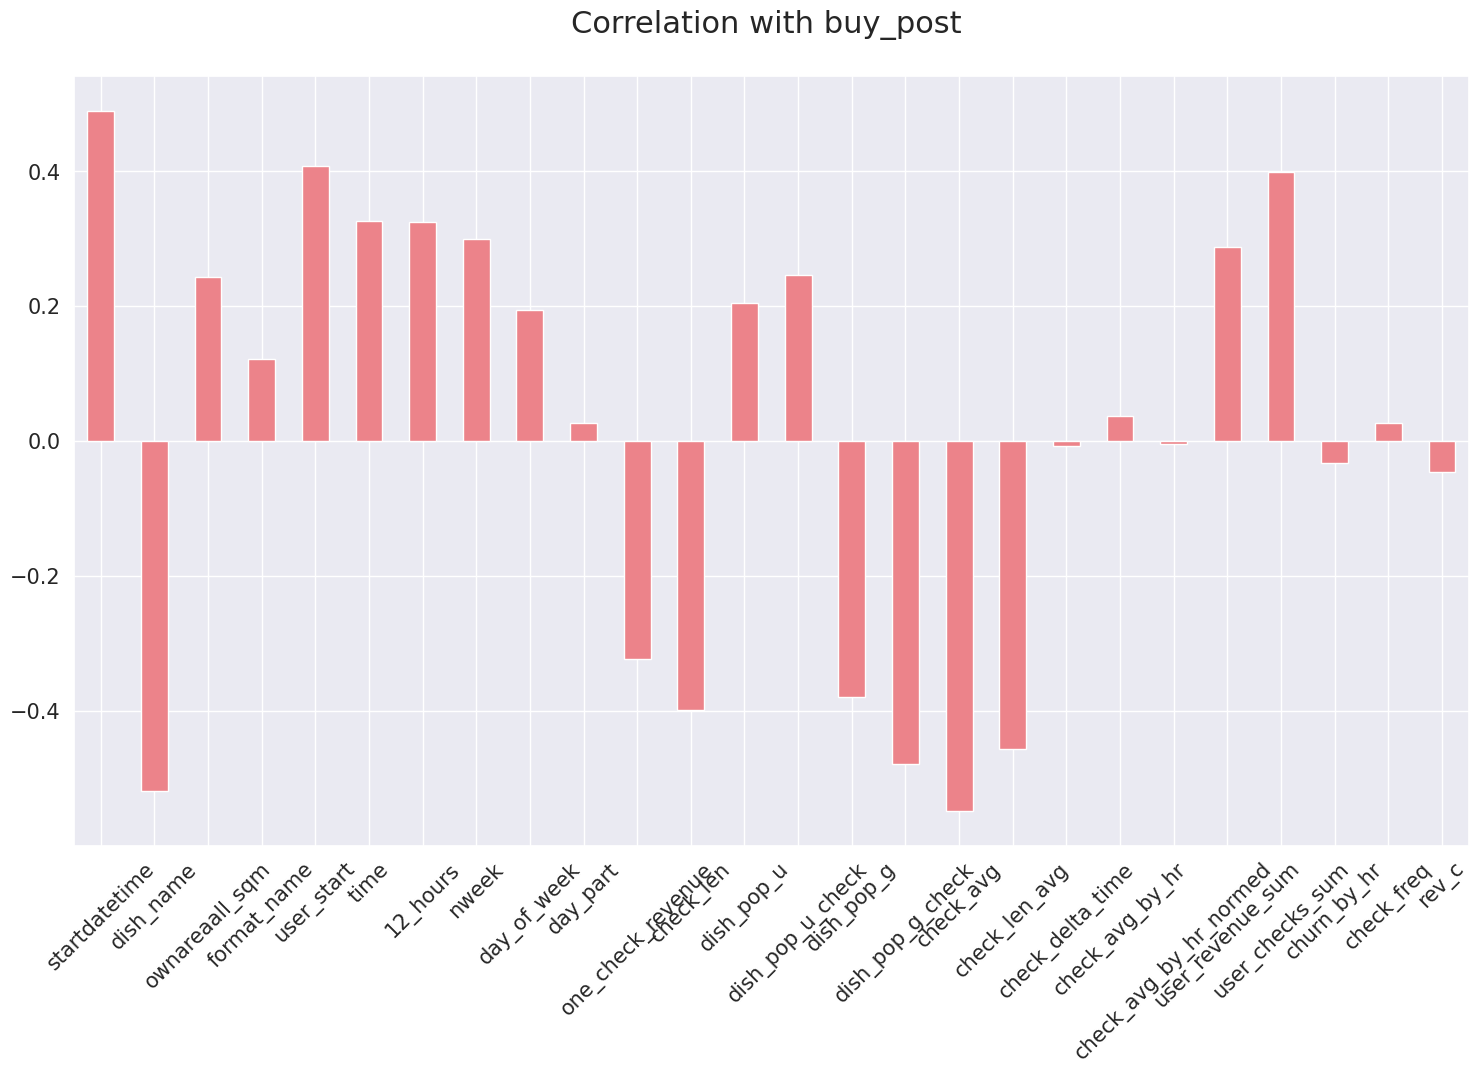

In [37]:
correlations = df_by_user.drop(columns=['buy_post', 'date_diff_post', 'customer_id']).corrwith(pd.Series(pr))
correlations = correlations[correlations!=1]
correlations.plot.bar(
        figsize = (18, 10), 
        fontsize = 15, 
        color = '#ec838a',
        rot = 45, grid = True)
plt.title('Correlation with buy_post \n', horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")

0.7824726134585289


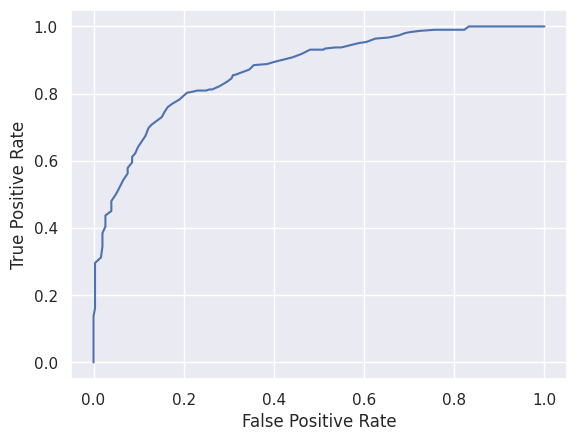

In [38]:
regressor = RandomForestClassifier( n_estimators=100, criterion = 'entropy', random_state = 0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print(f1_score(y_test, y_pred, pos_label=1, average='binary'))
y_pred_proba = regressor.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

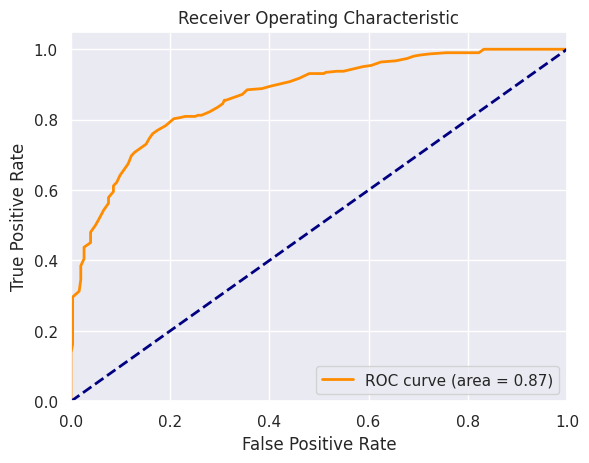

In [39]:
from sklearn.metrics import roc_curve, auc
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

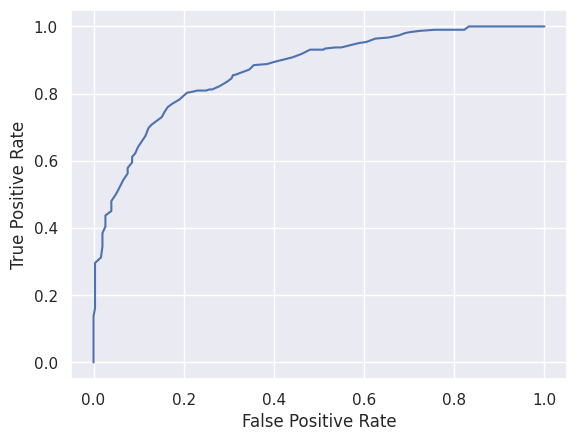

In [40]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

In [41]:
y_pred = regressor.predict(X_test)
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,

In [42]:
sum(y_pred) / len(y_pred)

0.5509868421052632

In [45]:
f1_sc = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
pr = precision_score(y_test, y_pred)
print(f1_sc)
print(acc)
print(pr)

0.7824726134585289
0.7713815789473685
0.746268656716418


### Начало обучение регрессора

In [47]:
X = df_by_user[:2000].copy()
y = X.pop("date_diff_post")
X = X.loc[:, features]

# y = data_s['date_diff_post']
# X = data_s.drop(columns=['buy_post', 'date_diff_post'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (1600, 17)
Number transactions y_train dataset:  (1600,)
Number transactions X_test dataset:  (400, 17)
Number transactions y_test dataset:  (400,)


In [48]:
sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_train2.columns = X_train.columns.values
X_train2.index = X_train.index.values
X_train = X_train2
X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_test2.columns = X_test.columns.values
X_test2.index = X_test.index.values
X_test = X_test2

#### Обучаем раз

In [49]:
# Calculate evaluation metrics
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
 
# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r_squared)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 23.219914042867448
Mean Squared Error (MSE): 849.4269244645674
R-squared (R²): 0.2542343351520264
Root Mean Squared Error (RMSE): 29.144929652764088


In [50]:
from sklearn.model_selection import RepeatedKFold
from numpy import mean
from numpy import std
from catboost import CatBoostClassifier

pd.options.mode.chained_assignment = None

#### Обучаем два

In [55]:
# Calculate evaluation metrics
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
cat_features = X_train.select_dtypes(include='object').columns.tolist()
model = CatBoostClassifier(n_estimators=100, max_depth=5, learning_rate=0.05, verbose=0, cat_features=cat_features)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

train_accuracy_score=model.score(X_train,y_train)
print(train_accuracy_score)

train_accuracy_score=model.score(X_test,y_test)
print(train_accuracy_score)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r_squared)
print("Root Mean Squared Error (RMSE):", rmse)

# n_scores = cross_val_score(model, X_test, y_test, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# print('MAE (Средняя Абсолютная Ошибка): %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

0.30875
0.2075
Mean Absolute Error (MAE): 50.5875
Mean Squared Error (MSE): 3858.1425
R-squared (R²): -2.3873075172468754
Root Mean Squared Error (RMSE): 62.11394770902909


#### Обучаем три

In [56]:
# Calculate evaluation metrics
model = RandomForestRegressor(n_estimators=100, criterion = 'squared_error', random_state = 0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

train_accuracy_score=model.score(X_train,y_train)
print(train_accuracy_score)

train_accuracy_score=model.score(X_test,y_test)
print(train_accuracy_score)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r_squared)
print("Root Mean Squared Error (RMSE):", rmse)

0.8857001874944319
0.23831108307286542
Mean Absolute Error (MAE): 23.448599999999995
Mean Squared Error (MSE): 867.563505
R-squared (R²): 0.23831108307286542
Root Mean Squared Error (RMSE): 29.454430990939205
